<a href="https://colab.research.google.com/github/shubh199815/FastAI-DL-1/blob/master/BIWI_head_pose_Regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg'

In [0]:
def img2txt_name(f):
  return path/f'{str(f)[:-7]}pose.txt'

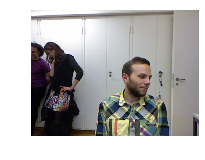

In [7]:
img = open_image(path/fname)
img.show()

In [8]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])
  
def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)
  
def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [11]:
get_ctr(fname)

tensor([263.9104, 428.5814])

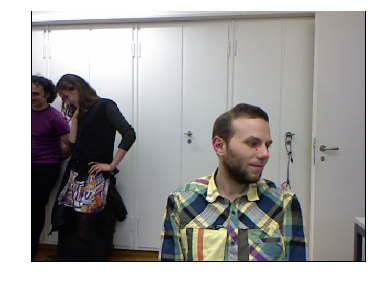

In [12]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6,6))

In [0]:
data = PointsItemList.from_folder(path).split_by_valid_func(lambda o: o.parent.name=='13').label_from_func(get_ctr).transform(get_transforms(), tfm_y=True, size=(120,160)).databunch().normalize(imagenet_stats)

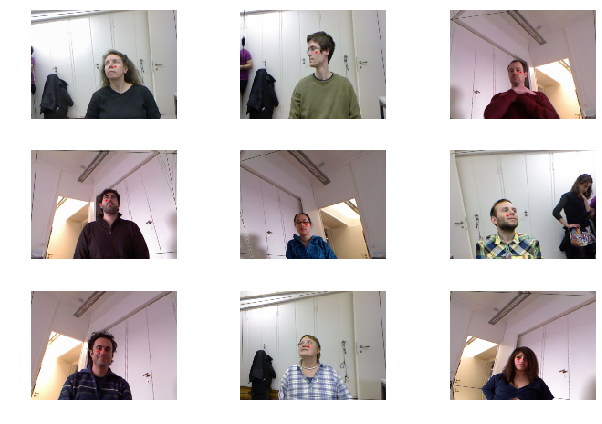

In [15]:
data.show_batch(3, figsize=(9,6))

In [16]:
learn = create_cnn(data, models.resnet34)
learn.loss_func = MSELossFlat()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 79312827.68it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


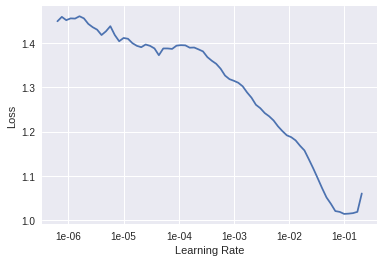

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr = 2e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
1,0.050824,0.008181,04:07
2,0.017730,0.002131,04:06
3,0.008439,0.004693,04:03
4,0.005041,0.001364,04:05
5,0.003882,0.001490,04:05


In [0]:
learn.save('stage-1-BIWI-rn34')